In [ ]:
from sentence_transformers import SentenceTransformer, util
import os
import sys
sys.path.append(os.path.abspath(".."))  

# Load model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # lightweight and fast

In [ ]:
# environment/LLM/rule_based_citation_rater.py

import re
from sentence_transformers import SentenceTransformer, util
from abc import ABC, abstractmethod
import numpy as np

class Rater(ABC):
    def __init__(self, llm=None, current_items_features_list=None, previous_items_features_list=None, llm_render=False, llm_query_explanation=False):
        self.llm = llm
        self.llm_render = llm_render
        self.llm_query_explanation = llm_query_explanation
        self.current_items_features_list = current_items_features_list if current_items_features_list else []
        self.previous_items_features_list = previous_items_features_list if previous_items_features_list else []

    @abstractmethod
    def query(self, user, item, num_interacted, interactions, retrieved_items):
        pass

class RuleBasedCitationRater(Rater):
    def __init__(self, 
                 bert_model=None, 
                 weight_topic=0.4, 
                 weight_novelty=0.3, 
                 weight_reputability=0.3):
        """
        Rule-Based Citation Rater.
        """
        super().__init__(llm=None)
        
        if bert_model is None:
            self.bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # default lightweight model
        else:
            self.bert_model = bert_model

        self.weight_topic = weight_topic
        self.weight_novelty = weight_novelty
        self.weight_reputability = weight_reputability

    def parse_user_preferences(self, user):
        """
        Parse novelty and reputability preferences from user description.
        """
        description = user.description

        novelty_match = re.search(r'Prefers novelty: ([0-9.]+)', description)
        reputability_match = re.search(r'reputability bias: ([0-9.]+)', description)
        
        

        novelty = float(novelty_match.group(1)) if novelty_match else 0.5
        reputability = float(reputability_match.group(1)) if reputability_match else 0.5

        return novelty, reputability

    def compute_semantic_topic_score(self, user, item):
        """
        Compute cosine similarity between user interests and paper (title + topics).
        """
        user_text = user.description.split("Prefers novelty")[0].lower()
        paper_text = (item.title + " " + " ".join(item.topics)).lower()

        print("User preference:", user_text)
        print("Paper description:", paper_text)
        # Encode
        user_emb = self.bert_model.encode(user_text, convert_to_tensor=True)
        title_emb = self.bert_model.encode(item.title.lower(), convert_to_tensor=True)
        topic_emb = self.bert_model.encode(" and".join(item.topics).lower(), convert_to_tensor=True)

        # Cosine similarity
        similarity_title = util.cos_sim(user_emb, title_emb).item()
        similarity_topic = util.cos_sim(user_emb, topic_emb).item()
        similarity = max(0, .2*similarity_title + .8*similarity_topic)  # Clamp to [0,1]
        # print(f"cosine similarity: {similarity}")


        return similarity

    def compute_novelty_score(self, novelty_pref, item):
        """
        Higher score if normalized year matches user's novelty preference.
        """
        return novelty_pref * item.norm_year
        return 1.0 - abs(novelty_pref - item.norm_year)

    def compute_reputability_score(self, reputability_bias, item):
        """
        Higher score if normalized citations match user's reputability bias.
        """
        return reputability_bias * item.norm_cite
        return 1.0 - abs(reputability_bias - item.norm_cite)

    def query(self, user, item, num_interacted=None, interactions=None, retrieved_items=None):
        """
        Query rating function — must match (rating, explanation, prompt).
        """
        novelty_pref, reputability_bias = self.parse_user_preferences(user)

        topic_score = self.compute_semantic_topic_score(user, item)
        if topic_score > 0.4:
            novelty_score = self.compute_novelty_score(novelty_pref, item)
            reputability_score = self.compute_reputability_score(reputability_bias, item)
        else:
            novelty_score = 0
            reputability_score = 0
        # print(f"Topic score: {topic_score}, Novelty score: {novelty_score}, Reputability score: {reputability_score}")
        final_score = (
            topic_score +
            novelty_score +
            reputability_score
        )
        print(f"Final score: ({topic_score} + {novelty_score} + {reputability_score})3= {final_score}\n\n")

        rating = round(final_score * 9)
        rating = min(9, max(0, rating))  # Clamp
        # print(f"Rating: {rating}")
        # print(np.random.rand())
        # clicked = np.random.rand() < rating

        # We return rating, empty explanation, empty prompt (for compatibility)
        return int(rating), "", ""


In [7]:
rating = round(0.2 * 9)
rating = min(9, max(0, rating))  # Clamp
rating

2

In [8]:
users_loader.get_users()[0].description

'Interested in: Complex Network Analysis Techniques. Prefers novelty: 0.66, reputability bias: 0.25'

In [9]:
import random
import pandas as pd
from environment.users.user import User
from environment.citations.citation import Citation


rater = RuleBasedCitationRater(
)
# --------------------------------------------
# Create the user
# --------------------------------------------
example_user = users_loader.get_users()[0]

# No need to manually add novelty_preference and reputability_bias manually!
# Now it will be automatically parsed from description text.

# --------------------------------------------
# Create two synthetic papers
# --------------------------------------------

# ✅ Relevant paper
relevant_paper = Citation(
    id=1000,
    title="Advances in Web Visibility",
    year=2022,
    topics=["Web visibility and informetrics", "Scientometrics"],
    topic_scores=[0.98, 0.95],
    cited_by_count=2500,
    norm_cite=0.9,
    norm_year=0.98
)

# ❌ Irrelevant paper
irrelevant_paper = Citation(
    id=1001,
    title="Crop Rotation Strategies in Agricultural Sciences",
    year=2010,
    topics=["Agricultural Sciences", "Crop Management"],
    topic_scores=[0.7, 0.65],
    cited_by_count=120,
    norm_cite=0.2,
    norm_year=0.6
)

# --------------------------------------------
# Query rule-based rater
# --------------------------------------------

rating_relevant, _, _ = rater.query(example_user, relevant_paper, 0, [], [])
rating_irrelevant, _, _ = rater.query(example_user, irrelevant_paper, 0, [], [])

# --------------------------------------------
# Display results
# --------------------------------------------
print("🧑‍💼 User Profile:")
print(f"  Description: {example_user.description}")

print("\n✅ Relevant Paper:")
print(f"  Title: {relevant_paper.title}")
print(f"  Topics: {relevant_paper.topics}")
print(f"  Norm Year: {relevant_paper.norm_year}")
print(f"  Norm Citations: {relevant_paper.norm_cite}")

print(f"\n🎯 Predicted Rating for Relevant Paper: {rating_relevant}")

print("\n❌ Irrelevant Paper:")
print(f"  Title: {irrelevant_paper.title}")
print(f"  Topics: {irrelevant_paper.topics}")
print(f"  Norm Year: {irrelevant_paper.norm_year}")
print(f"  Norm Citations: {irrelevant_paper.norm_cite}")

print(f"\n🚫 Predicted Rating for Irrelevant Paper: {rating_irrelevant}")


User preference: interested in: complex network analysis techniques. 
Paper description: advances in web visibility web visibility and informetrics scientometrics
Final score: (0.21210566461086275 + 0 + 0)3= 0.21210566461086275


User preference: interested in: complex network analysis techniques. 
Paper description: crop rotation strategies in agricultural sciences agricultural sciences crop management
Final score: (0.0768310621380806 + 0 + 0)3= 0.0768310621380806


🧑‍💼 User Profile:
  Description: Interested in: Complex Network Analysis Techniques. Prefers novelty: 0.66, reputability bias: 0.25

✅ Relevant Paper:
  Title: Advances in Web Visibility
  Topics: ['Web visibility and informetrics', 'Scientometrics']
  Norm Year: 0.98
  Norm Citations: 0.9

🎯 Predicted Rating for Relevant Paper: 2

❌ Irrelevant Paper:
  Title: Crop Rotation Strategies in Agricultural Sciences
  Topics: ['Agricultural Sciences', 'Crop Management']
  Norm Year: 0.6
  Norm Citations: 0.2

🚫 Predicted Rating f

In [10]:
import os
import string
from functools import reduce

import gymnasium as gym
import numpy as np
import pandas as pd
import torch
from gymnasium import spaces
from sentence_transformers import SentenceTransformer

from environment.item import ItemsLoader
from environment.items_retrieval import ItemsRetrieval
from environment.items_selection import ItemsSelector
from environment.LLM import LLMRater
from environment.memory import Memory
from environment.reward_perturbator import RewardPerturbator
from environment.reward_shaping import RewardShaping
from environment.users import UsersLoader

class Simulatio4RecSys(gym.Env):
    def __init__(
        self,
        render_mode: str,
        items_loader: ItemsLoader,
        users_loader: UsersLoader,
        items_selector: ItemsSelector,
        reward_perturbator: RewardPerturbator,
        items_retrieval: ItemsRetrieval,
        reward_shaping: RewardShaping,
        llm_rater: LLMRater,
        render_path: str = "./tmp/render/",
        evaluation: bool = False,
    ):
        self.render_mode = render_mode
        self.render_path = render_path
        self.metadata = {"render_modes": ["human", "csv"]}

        self.users_loader = users_loader
        self.user_list = self.users_loader.get_users()
        self.num_users = len(self.user_list)

        self.items_loader = items_loader
        self.item_ids = self.items_loader.load_all_ids()
        self.num_items = len(self.item_ids)

        self.action_to_item = {idx: id for idx, id in enumerate(self.item_ids)}
        self.item_to_action = {id: idx for idx, id in enumerate(self.item_ids)}

        self.memory = Memory(self.items_loader)
        self.items_retrieval = items_retrieval
        self.items_selector = items_selector
        self.reward_perturbator = reward_perturbator
        self.llm_rater = llm_rater
        self.llm_seed = 0
        self.reward_shaping = reward_shaping
        self.evaluation = evaluation
        self.evaluation_previous_user_id = None
        self.evaluation_count = 0

        # ✅ BERT model for embeddings
        self.bert_model = SentenceTransformer('all-MiniLM-L6-v2')

        # ✅ Updated observation space
        self.observation_space = spaces.Dict({
            "user_gender": spaces.Box(low=0, high=1, shape=(1,), dtype=np.int32),
            "user_age": spaces.Box(low=0, high=120, shape=(1,), dtype=np.int32),
            "novelty_preference": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            "reputability_bias": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            "item_norm_year": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            "item_norm_cite": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            "user_topic_embedding": spaces.Box(low=-1.0, high=1.0, shape=(384,), dtype=np.float32),
            "item_topic_embedding": spaces.Box(low=-1.0, high=1.0, shape=(384,), dtype=np.float32),
        })

        self.action_space = spaces.Discrete(self.num_items)

    def reset(self, seed=None, options=None, user_id=None):
        super().reset(seed=seed)
        self.clean_memory()

        if seed is not None:
            self.items_selector.seed(seed)
            self.reward_perturbator.seed(seed)
            self.llm_seed = seed

        if user_id is None and not self.evaluation:
            user_id = self.np_random.integers(low=0, high=self.num_users)
        elif self.evaluation:
            if self.evaluation_previous_user_id is None:
                user_id = 0
                self.evaluation_count = 0
            else:
                user_id = self.evaluation_previous_user_id + 1
                self.evaluation_count = 0

        self._user = self.user_list[user_id]
        self._items_interact = tuple()

        # ✅ Embed user's research description
        self._user_topic_embedding = self.bert_model.encode(self._user.description)

        observation = self._get_obs(curr_item=None)
        info = {}
        return observation, info

    def step(self, action: int):
        item_id = self.action_to_item[action]
        curr_item = self.items_loader.load_items_from_ids(id_list=[item_id])[0]

        past_items, past_interactions = self.memory.get_items_and_scores(self._user.id)
        num_interacted = self.memory.get_num_interaction(self._user.id, item_id)

        retrieved_items, retrieved_interactions = self.items_retrieval.retrieve(curr_item, past_items, past_interactions)

        # ✅ Embed paper title + topics
        paper_text = curr_item.title + " " + " ".join(curr_item.topics)
        self._item_topic_embedding = self.bert_model.encode(paper_text)

        torch.manual_seed(self.llm_seed)
        rating, explanation, html_interaction = self.llm_rater.query(
            self._user,
            curr_item,
            num_interacted,
            past_interactions,
            retrieved_items,
        )
        self.llm_seed += 1

        selected_items, selected_ratings = self.items_selector.select([curr_item], [rating])
        selected_items, selected_ratings = self.reward_perturbator.perturb([curr_item], [rating])

        selected_items_ids = [m.id for m in selected_items]
        self.memory.update_memory(self._user.id, selected_items_ids, selected_ratings)

        self._items_interact = self._items_interact + (
            np.array([self.item_to_action[selected_items_ids[0]], selected_ratings[0]], dtype=np.int_),
        )

        terminated = self.np_random.choice([True, False], p=[0.025, 0.975])

        observation = self._get_obs(curr_item=curr_item)

        reward = reduce(lambda x, y: x + y, selected_ratings)

        info = {
            "LLM_explanation": explanation,
            "LLM_rating": rating,
            "LLM_interaction_HTML": html_interaction,
        }

        item_interaction = self.memory.user_to_seen_films[self._user.id][item_id]
        reward, reward_shaping_termination = self.reward_shaping.reshape(item_interaction, reward)
        if reward_shaping_termination:
            terminated = True

        if self.evaluation:
            self.evaluation_previous_user_id = self._user.id
            self.evaluation_count += 1
            terminated = False
            if self.evaluation_count == 11:
                terminated = True

        return observation, reward, terminated, False, info

    def _get_obs(self, curr_item=None):
        gender = 0 if self._user.gender == "M" else 1
        novelty, reputability = self.parse_preferences_from_description(self._user.description)

        obs = {
            "user_gender": np.array([gender], dtype=np.int32),
            "user_age": np.array([self._user.age], dtype=np.int32),
            "novelty_preference": np.array([novelty], dtype=np.float32),
            "reputability_bias": np.array([reputability], dtype=np.float32),
            "item_norm_year": np.array([0.0], dtype=np.float32),
            "item_norm_cite": np.array([0.0], dtype=np.float32),
            "user_topic_embedding": self._user_topic_embedding,
            "item_topic_embedding": np.zeros(384, dtype=np.float32),
        }

        if curr_item is not None:
            obs["item_norm_year"] = np.array([curr_item.norm_year], dtype=np.float32)
            obs["item_norm_cite"] = np.array([curr_item.norm_cite], dtype=np.float32)
            obs["item_topic_embedding"] = self._item_topic_embedding

        return obs

    def parse_preferences_from_description(self, description):
        import re
        novelty_match = re.search(r'Prefers novelty: ([0-9.]+)', description)
        reputability_match = re.search(r'reputability bias: ([0-9.]+)', description)

        novelty = float(novelty_match.group(1)) if novelty_match else 0.5
        reputability = float(reputability_match.group(1)) if reputability_match else 0.5
        return novelty, reputability

    def clean_memory(self):
        self.memory = Memory(self.items_loader)


import gymnasium as gym
import numpy as np
from gymnasium import spaces

class FlatObsWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

        # ✅ Define flat observation space including embeddings
        self.observation_space = spaces.Dict({
            "user_gender": spaces.Box(low=0, high=1, shape=(1,), dtype=np.int32),
            "user_age": spaces.Box(low=0, high=120, shape=(1,), dtype=np.int32),
            "novelty_preference": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            "reputability_bias": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            "item_norm_year": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            "item_norm_cite": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            "user_topic_embedding": spaces.Box(low=-1.0, high=1.0, shape=(384,), dtype=np.float32),
            "item_topic_embedding": spaces.Box(low=-1.0, high=1.0, shape=(384,), dtype=np.float32),
        })

        self.action_space = env.action_space  # Delegate to base env

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return self._transform_obs(obs), info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        return self._transform_obs(obs), reward, terminated, truncated, info

    def _transform_obs(self, obs):
        # No major transformation needed, just fix data types if necessary
        return {
            "user_gender": np.array(obs["user_gender"], dtype=np.int32),
            "user_age": np.array(obs["user_age"], dtype=np.int32),
            "novelty_preference": np.array(obs["novelty_preference"], dtype=np.float32),
            "reputability_bias": np.array(obs["reputability_bias"], dtype=np.float32),
            "item_norm_year": np.array(obs["item_norm_year"], dtype=np.float32),
            "item_norm_cite": np.array(obs["item_norm_cite"], dtype=np.float32),
            "user_topic_embedding": np.array(obs["user_topic_embedding"], dtype=np.float32),
            "item_topic_embedding": np.array(obs["item_topic_embedding"], dtype=np.float32),
        }


In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU

import sys
sys.path.append(os.path.abspath(".."))  

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

# Project Imports
# from environment.env import Simulatio4RecSys
from environment.items_selection import GreedySelector
from environment.reward_perturbator import NoPerturbator
from environment.reward_shaping import IdentityRewardShaping
from environment.citations.citation_loader import CitationsLoader
from environment.citations.citations_retrieval import CitationsRetrieval
from environment.users.citation_users_loader import CitationUsersLoader
# from environment.LLM.small_hf_llm import SmallHuggingfaceLLM
# from environment.flat_obs_wrapper import FlatObsWrapper
# from environment.LLM.rater import CitationLLMRater



# from sentence_transformers import SentenceTransformer
# bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# --- New Smart Rater ---
# from environment.LLM.rule_based_citation_rater import RuleBasedCitationRater
rater = RuleBasedCitationRater(bert_model=bert_model)


csv_path = "../environment/citations/datasets/cleaned-scientometrics-and-bibliometrics-research.csv"
users_path = "../environment/users/datasets/selected_users.json"

items_loader = CitationsLoader(csv_path)
users_loader = CitationUsersLoader(users_path)

# --- Environment ---
raw_env = Simulatio4RecSys(
    render_mode="human",
    items_loader=items_loader,
    users_loader=users_loader,
    items_selector=GreedySelector(),
    reward_perturbator=NoPerturbator(),
    items_retrieval=CitationsRetrieval(),
    reward_shaping=IdentityRewardShaping(),
    llm_rater=rater    
)

env = FlatObsWrapper(raw_env)
env = Monitor(env)


In [ ]:
model = DQN("MultiInputPolicy", env, verbose=1, 
            device="cpu",
            exploration_fraction=0.1, 
            learning_starts=1000, buffer_size=50000, batch_size=32)
model.learn(total_timesteps=10000)
# model.save("models/dqn_citation_recommender_rule")

# ===============================
# Plot Rewards
# ===============================

rewards = env.get_episode_rewards()
plt.figure(figsize=(12, 5))
plt.plot(rewards)
plt.title("DQN - Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()



Using cpu device
Wrapping the env in a DummyVecEnv.
User preference: interested in: complex network analysis techniques. 
Paper description: open research world : australian funder mandates, deakin policy and open publishing opportunities scientometrics and bibliometrics research academic publishing and open access
Final score: (0.14786286242306235 + 0 + 0)3= 0.14786286242306235


User preference: interested in: complex network analysis techniques. 
Paper description: characterization of the scientific production of the national school of public health included in scopus database, 2006-2012 scientometrics and bibliometrics research health and medical research impacts academic publishing and open access
Final score: (0.07475937753915787 + 0 + 0)3= 0.07475937753915787


User preference: interested in: complex network analysis techniques. 
Paper description: subject guides: resources for academic publishing: teach yourself: scholarly publishing+finding the journal scientometrics and bibli

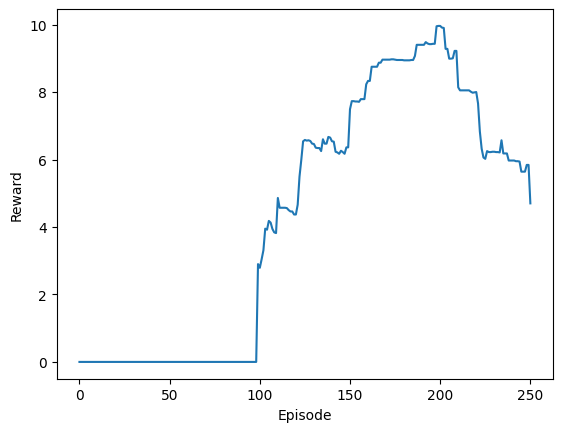

In [308]:
import torch
def plot_rewards(episode_rewards, window_size=100):
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    if len(rewards_t) >= window_size:
        means = rewards_t.unfold(0, window_size, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(window_size-1), means))
        plt.plot(means.numpy())

plot_rewards(rewards)


In [ ]:
model.save("models/dqn_citation_recommender_rule")

In [ ]:
import numpy as np

def evaluate_precision_at_k(env, model, rater, users_loader, K=5, threshold=6):
    """
    Evaluate Precision@K across first `num_users_eval` users.

    Args:
        env: The environment (wrapped with Monitor, FlatObsWrapper, etc.)
        model: Trained RL model (e.g., DQN, A2C)
        rater: LLMRater or RuleBasedRater to simulate user feedback
        users_loader: Loader to access users
        K: Number of top recommendations
        threshold: Minimum score to count as a "click"
        num_users_eval: Number of users to evaluate (default 2)

    Returns:
        mean_precision: Mean precision@K across users
    """

    all_precisions = []
    n_users = len(users_loader.get_users())
    # num_users_eval = min(num_users_eval, n_users)

    for user_idx in range(n_users):
        obs = env.reset()[0]
        user = users_loader.get_users()[user_idx]

        clicked = []
        recommended_actions = set()

        print(f"\n🔵 User {user_idx}: {user.description}")

        for rec_idx in range(K):
            action, _ = model.predict(obs, deterministic=True)
            action = int(action)

            # Avoid recommending the same paper again
            while action in recommended_actions:
                action = env.action_space.sample()
                action = int(action)

            recommended_actions.add(action)

            item_id = env.unwrapped.action_to_item[action]
            paper = env.unwrapped.items_loader.load_items_from_ids([item_id])[0]

            print(f"    ➔ Recommendation {rec_idx+1}: Paper ID {item_id} - {paper.title} - {paper.topics} - {paper.norm_year:.2f} - {paper.norm_cite:.2f}")


            # Get simulated "rating" from user for this paper
            rating, _, _ = rater.query(user, paper, 0, [], [])
            # print(rating)

            # Check if user "clicked" (liked it)
            click = rating >= threshold
            clicked.append(click)
            print(click)

            # Step environment
            obs, reward, done, truncated, info = env.step(action)
            

            # click = reward
            # clicked.append(click)
            # print(click)


            if done or truncated:
                obs = env.reset()[0]

        precision = np.sum(clicked) / K
        all_precisions.append(precision)

    mean_precision = np.mean(all_precisions)
    print(f"\n📊 Precision@{K}: {mean_precision:.4f}")
    return mean_precision
mean_precision = evaluate_precision_at_k(env, model, rater, users_loader, K=5, threshold=4)


🔵 User 0: Interested in: Complex Network Analysis Techniques. Prefers novelty: 0.66, reputability bias: 0.25
    ➔ Recommendation 1: Paper ID 32392 - VASCULAR RESPONSE TO EVEROLIMUS AND BIOLIMUS-ELUTING CORONARY STENTS VERSUS EVEROLIMUS-ELUTING BIORESORBABLE SCAFFOLDS: AN OPTICAL COHERENCE TOMOGRAPHY SUBSTUDY OF THE EVERBIO II TRIAL - ['scientometrics and bibliometrics research', 'Electrochemical Analysis and Applications', 'Atmospheric and Environmental Gas Dynamics'] - 0.99 - 0.00
User preference: interested in: complex network analysis techniques. 
Paper description: vascular response to everolimus and biolimus-eluting coronary stents versus everolimus-eluting bioresorbable scaffolds: an optical coherence tomography substudy of the everbio ii trial scientometrics and bibliometrics research electrochemical analysis and applications atmospheric and environmental gas dynamics
Final score: (0.08220294415950775 + 0 + 0)3= 0.08220294415950775


User preference: interested in: academic pu